In [53]:
from flask import Flask, request, redirect, url_for,send_from_directory, render_template_string
from werkzeug.utils import secure_filename
import caffe
import json
import numpy as np
import os
from sklearn import svm,metrics
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import struct
import pandas as pd

Train: 2182 Test:243
Ratio: 9:1

In [2]:
deployPrototxt = "/opt/swm-ml-docker/swm-ml-master/bvlc_reference_caffenet/deploy.prototxt"
caffeModel = "/opt/swm-ml-docker/swm-ml-master/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel"
featureVectorDirectory = "/opt/swm-ml-docker/data/train"
metadataDirectory = '/opt/swm-ml-docker/metadata_bak/'
imageMeanFile = '/opt/swm-ml-docker/ilsvrc_2012_mean.npy'
layerName = 'fc7'

In [3]:
print("Loading model ...")
cnn = caffe.Net(deployPrototxt, caffe.TEST, weights=caffeModel)
print("Done loading")

Loading model ...
Done loading


In [4]:
# reshape to accept one image at a time.
(_, c, w, h) = cnn.blobs['data'].data.shape
cnn.blobs['data'].reshape(1, c, w, h)
transformer = caffe.io.Transformer({'data': cnn.blobs['data'].data.shape})
transformer.set_mean('data', np.load(imageMeanFile).mean(1).mean(1))
transformer.set_transpose('data', (2,0,1))
transformer.set_raw_scale('data', 255.0)

In [107]:
def loadFeatureVectors(dirPath, d):
    """
    Loads all feature vectors from the local directory into a single nxd matrix
    where n is the number of feature vectors and the d is the dimensionality.
    Returns the matrix and a list of file names in one-to-one correspondence
    with the rows of the matrix.
    """
    allFiles = os.listdir(dirPath)
    data = np.zeros([len(allFiles), d])
    for i, fileName in enumerate(allFiles):
        #print (i,fileName)
        with open("%s/%s" % (dirPath, fileName), "rb") as inputFile:
            data[i] = struct.unpack('f'*d, inputFile.read())
    return (data, allFiles)

def loadMetaData(metadataDir):
    metadataByImageHash = {}
    allFiles = os.listdir(metadataDir)
    for fileName in allFiles:
        with open("%s/%s" % (metadataDir, fileName), "r") as jsonFile:
            metadata = json.load(jsonFile)
            metadataByImageHash[metadata['Image Hash']] = metadata
    return metadataByImageHash

# Simple case
def makeBinaryLabels(metadataByImageHash, allImageHashes):
    labels = []
    for imageHash in allImageHashes:
        metadata = metadataByImageHash[imageHash]
        labels.append(1 if (metadata['Secondary'] == "NA") else 0)
    return labels

In [6]:
print("Training SVM")
data, allImageHashes = loadFeatureVectors(featureVectorDirectory, d = 4096)
metadataByImageHash = loadMetaData(metadataDirectory)
labels = makeBinaryLabels(metadataByImageHash, allImageHashes)
clf = svm.SVC(probability=True)
clf.fit(data, labels)
print("Finished training ready to classify images")

Training SVM
Finished training ready to classify images


In [108]:
featureVectorTestDirectory = "/opt/swm-ml-docker/data/test"
dataTest, allImageHashesTest = loadFeatureVectors(featureVectorTestDirectory, d = 4096)
labelsTest = makeBinaryLabels(metadataByImageHash, allImageHashesTest)

(0, 'e78cb95bb8e85a9d382b301dc11fe9239fbc58451ece8b66f825eeaf3868829e')
(1, 'fbe2f277640e71520dd54d1010b959db221f46c8349f7263dd368d20c991aaa9')
(2, 'e918ea09c771e0a986a38613ec46f0f277599eae5f56abd05535549cfd8b1b4f')
(3, 'f51d1cf6c495925217766f6b9520fadac1e2a0dc52c6687c8f316836ad864cf4')
(4, 'f714e849facae3bc344cb4d951cc6fbfd3dad75f948489916417e6361bce9ad5')
(5, 'e4d7c941207e3e2d037a0d103f42a244883169c0c10ccff6e18a1a24d882b12c')
(6, 'f110d65d4e3bddcb783dd6ab324ebc8cbc4bbff3d51a6516aa3c8df96c4ed7db')
(7, 'f00ed429c5ff436d550cb188b9dbc39e32aec9bcc640a5147ef3e04a9a5fd3e7')
(8, 'eae9cd8930802391c2ad8417f02d74d4973f2f1df0dacf725c0a950c5c8ab938')
(9, 'e7570d84b231f22cdb9537c0025d11dc65c3924d1142a1c88488f1cbe2c6eaba')
(10, 'ec463c44a8f696595d7101c116a53745f56dcebd20473218b89a6b9d6a4a84da')
(11, 'eaa4ffc7376cfdf4ec613898706cce1677208f8b13d65b564b0bcd36384395ab')
(12, 'f8a3254265148d096064c16b14134a397b38e3b3bff3654eef24e5c7f30aa561')
(13, 'f250f60c44d970d2a439de212d2689ec3c9a9cc262e183b9707f87c

In [8]:
clf.score(dataTest,labelsTest)

0.80246913580246915

In [9]:
prediction=clf.predict(dataTest)

In [77]:
print clf.predict(np.expand_dims(dataTest[12], axis=0))
print labelsTest[12]

[1]
0


In [12]:
CM = metrics.confusion_matrix(labelsTest,prediction)

In [13]:
print CM

[[ 70  36]
 [ 12 125]]


In [146]:
fpr,tpr,thesholds=metrics.roc_curve(labelsTest,prediction)

In [15]:
%%bash
caffe --version

caffe version 1.0.0


# False Positive Analysis

In [ ]:
i=0
file=open("FP.txt",'w')
while i<len(prediction):
    if prediction[i]==1 and labelsTest[i]==0:
        file.write(str(i))
        file.write('\n')
    i=i+1
file.close()        
        

In [117]:
#filepath1="/opt/swm-ml-docker/data/test.txt"
allFiles = os.listdir(featureVectorTestDirectory)

filepath2="/opt/swm-ml-docker/data/FP.txt"
file=open("FP_imageName.txt",'w')
l=[]
with open(filepath2,'r') as fp:
    for line in fp:
        l.append(int(line))
       

i=0
FPImageHashes=[]

for line in allFiles:
        if i in l:
            line = line.strip('\n')
            file.write(line+".jpg")
            file.write('\n')
            FPImageHashes.append(line)
            #print(i,line)
        i=i+1
file.close()               

In [92]:
imageName=[]
file=open("imageNameFP.txt",'w')
for i in FPImageHashes:
    metadata=metadataByImageHash[i]
    file.write(metadata["Image Name"])
    file.write('\n')
file.close()

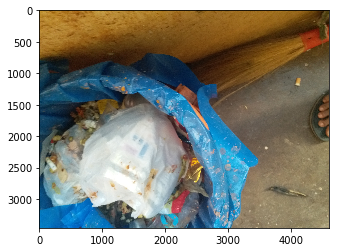

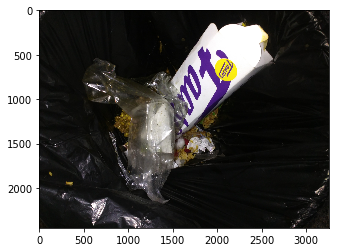

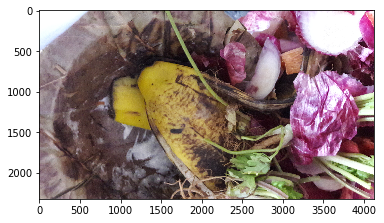

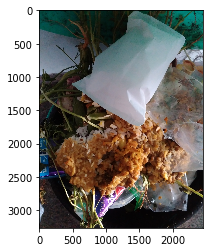

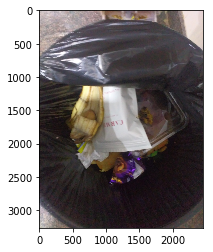

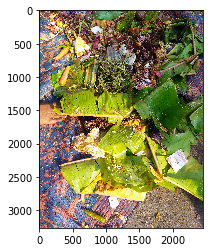

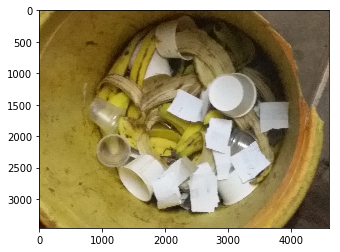

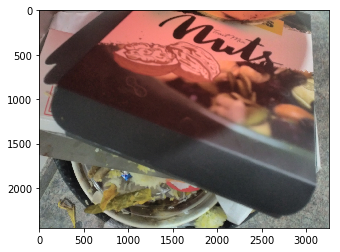

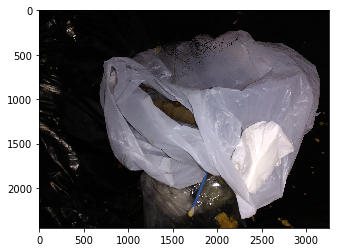

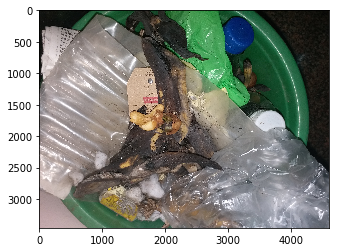

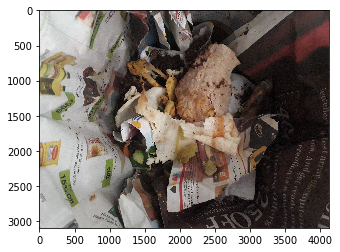

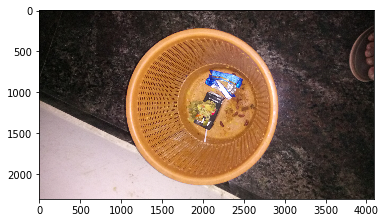

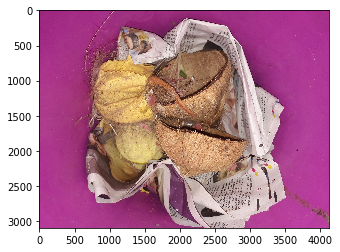

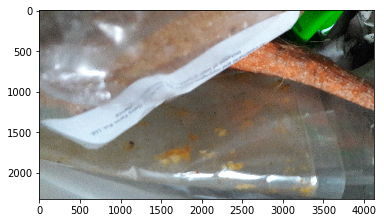

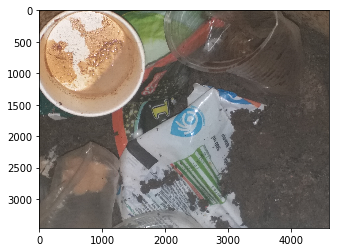

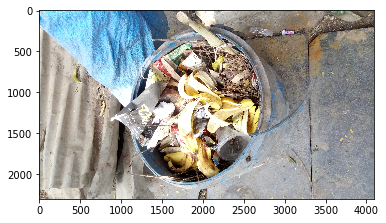

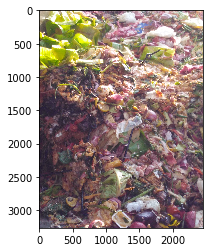

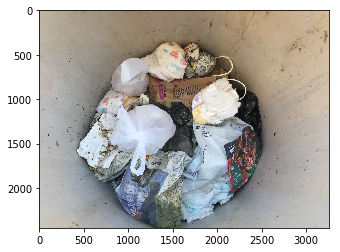

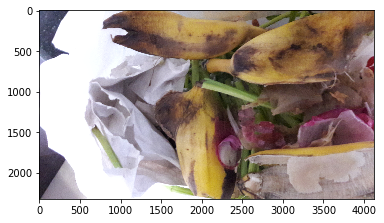

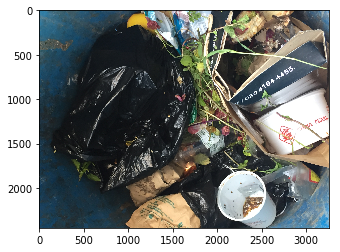

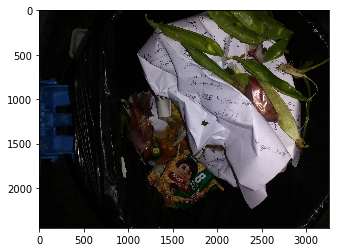

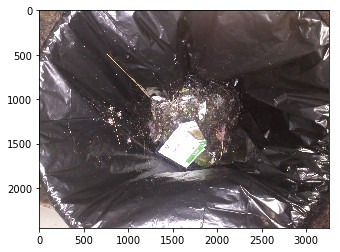

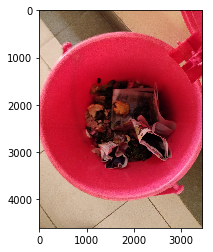

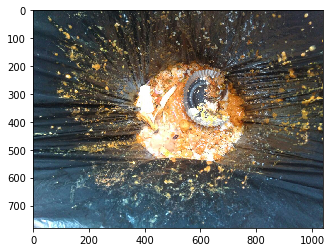

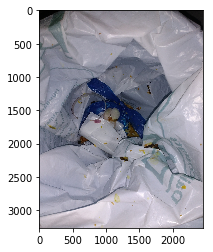

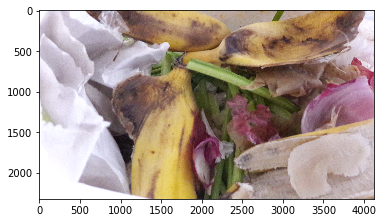

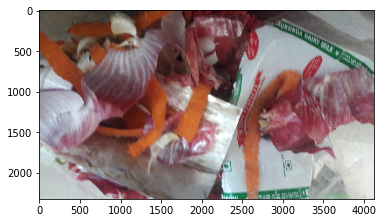

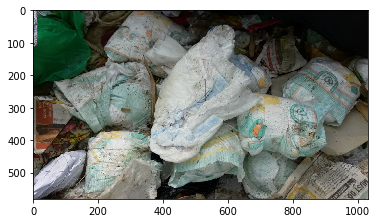

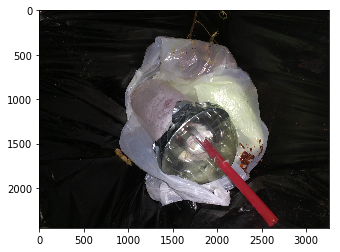

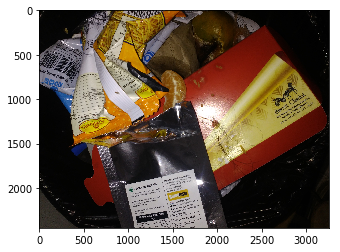

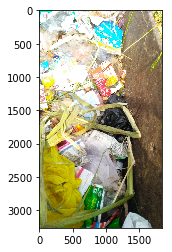

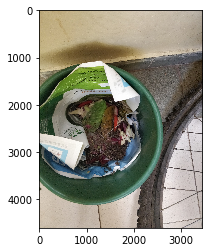

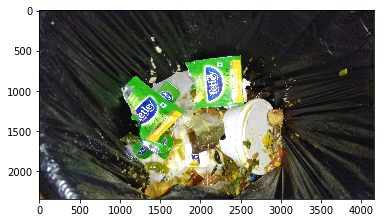

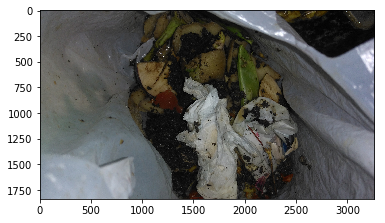

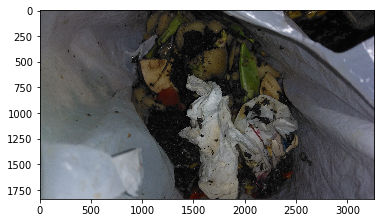

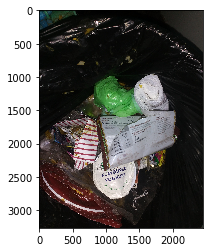

In [93]:
filepath="/opt/swm-ml-docker/images_bak/"
for i in FPImageHashes:
    s=filepath+i+".jpg"
    img=mpimg.imread(s)
    imgplot = plt.imshow(img)
    plt.show()

In [144]:
df = pd.read_csv('Consolidated.csv')
filepath='imageNameFP.txt'
imageName=[]
with open(filepath,'r') as fp:
    for line in fp:
      line =line.strip('\n')
      imageName.append(line)
print len(imageName)
#data= df.loc[df['Image Name'].isin(imageName)]
data=df[df["Image Name"].isin(imageName) == True]
print len(data)
data.to_csv('FP.csv', sep='\t')

l=df["Image Name"].values
for i in imageName:
    if i not in l:
        print i
       

36
30
20180126_071246.jpg
20180124_200445.jpg
20180131_061603.jpg
20180124_200503.jpg
IMG-20180208-WA0008.jpg
IMG-20180120-WA0017.jpg


# False Negative Analysis

In [17]:
i=0
file=open("FN.txt",'w')
while i<len(prediction):
    if prediction[i]==0 and labelsTest[i]==1:
        file.write(str(i))
        file.write('\n')
    i=i+1
file.close()  

In [112]:
#filepath1="/opt/swm-ml-docker/data/test.txt"
allFiles = os.listdir(featureVectorTestDirectory)
filepath2="/opt/swm-ml-docker/notebooks/FN.txt"
file=open("FN_imageName.txt",'w')
l=[]
with open(filepath2,'r') as fp:
    for line in fp:
        l.append(int(line))

i=0
FNImageHashes=[]
for line in allFiles:
    if i in l:
        line = line.strip('\n')
        file.write(line+".jpg")
        file.write('\n')
        FNImageHashes.append(line)
    i=i+1
file.close()  

In [113]:
imageNameFN=[]
file=open("imageNameFN.txt",'w')
for i in FNImageHashes:
    metadata=metadataByImageHash[i]
    file.write(metadata["Image Name"])
    file.write('\n')
    imageNameFN.append(metadata["Image Name"])
file.close()

In [114]:
%%bash
cd ..
pwd

/opt/swm-ml-docker


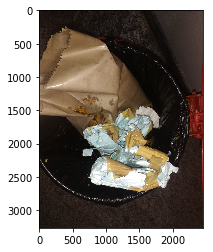

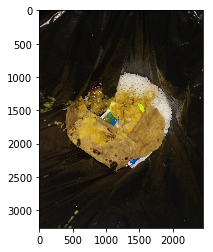

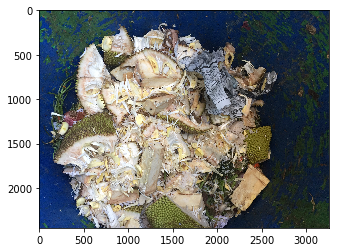

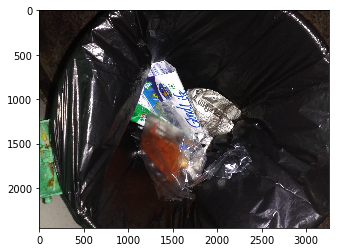

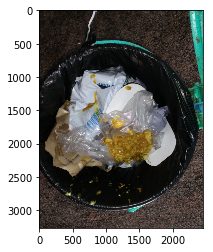

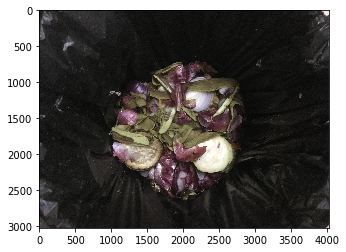

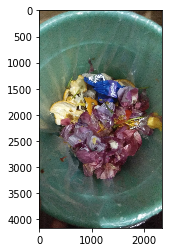

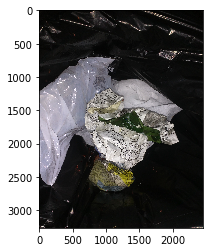

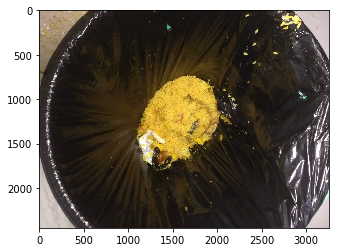

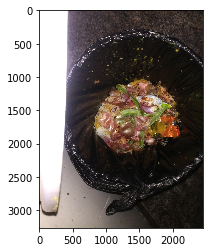

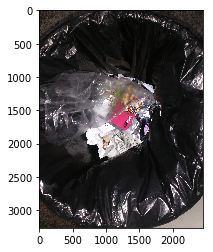

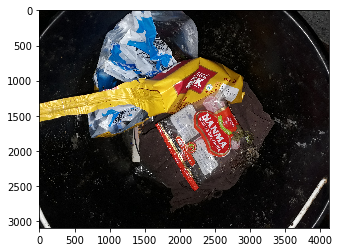

In [115]:
filepath="/opt/swm-ml-docker/images_bak/"
for i in FNImageHashes:
    s=filepath+i+".jpg"
    img=mpimg.imread(s)
    imgplot = plt.imshow(img)
    plt.show()

    

In [116]:
df = pd.read_csv('Consolidated.csv')
filepath='imageNameFN.txt'
imageName=[]
with open(filepath,'r') as fp:
   for line in fp:
     line =line.strip('\n')
     imageName.append(line)
#print imageName
data= df.loc[df['Image Name'].isin(imageName)]
data.to_csv('FN.csv', sep='\t')